# Example of american option pricing with DNN

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import keras.backend as K

from Loss import profit_loss
from Networks import AmericanOptionNetwork_1
from DataGeneration import stock_prices_generator
from Utils import EuroOptionPrice_MonteCarlo

Using TensorFlow backend.


Choosing model parameters:

In [2]:
interest_rate=0.05
volatility=0.3
T=1
S0=5
strike=5
num_samples=50 # batchsize
num_steps=100
option_type='call'

Initializing stock price generators:

In [3]:
# For neural network batch generation:
stockpricegenerator_NN=stock_prices_generator(mu=interest_rate, sigma=volatility, S0=S0, T=T, T_past=0, 
                                                modelinput=True, num_samples=num_samples, 
                                                  num_steps=num_steps)
# For comparison reasons:
stockpricegenerator_simple=stock_prices_generator(mu=interest_rate, sigma=volatility, S0=S0, T=T, T_past=0,
                                                    modelinput=False, num_samples=num_samples, 
                                                      num_steps=num_steps)

Constructing the network:

In [4]:
network=AmericanOptionNetwork_1(timesteps=num_steps,
                            num_initial_features=20,
                            num_hidden_features=(10,5,2),
                            hidden_activation='elu',
                            concat_timepoints=(True, False, False))

Creating loss function:

In [5]:
profitloss=profit_loss(strike=strike, interest_rate=interest_rate, T=T, option_type=option_type)

Compiling the network:

In [6]:
network.compile(loss=profitloss, optimizer='adam')

Fitting the network:

In [7]:
network.fit_generator(generator=stockpricegenerator_NN, epochs=8, steps_per_epoch=1000)

Epoch 1/8
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5571
Epoch 2/8
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6710
Epoch 3/8
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6863
Epoch 4/8
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6827
Epoch 5/8
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6870
Epoch 6/8
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6929
Epoch 7/8
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6966
Epoch 8/8
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6955


Plotting the network:

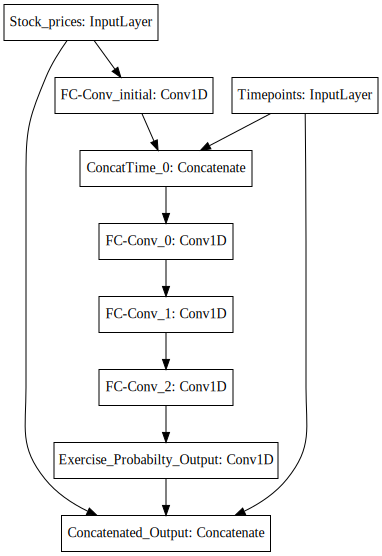

In [8]:
# Plotting to file:
from keras.utils import plot_model
import matplotlib.image as mpimg
plot_model(network, to_file='./network.png', show_shapes=True, show_layer_names=True)

# Plotting to inline output:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(network, show_shapes=False, show_layer_names=True).create(prog='dot', format='svg'))

### Evaluating model:
computing approximation of American option price with the NN model: 

In [9]:
# defining generator for evaluation of the trained network (more samples)
stockpricegenerator_NNeval=stock_prices_generator(mu=interest_rate, sigma=volatility, S0=S0, T=T, T_past=0, 
                                                modelinput=True, num_samples=100000, 
                                                num_steps=num_steps)

# minus Loss corresponds to the option price
-network.evaluate_generator(stockpricegenerator_NNeval, steps=1)

0.6993938088417053

Comparing with european option price (for call this should the same, for put EU smaller)

In [10]:
EuroOptionPrice_MonteCarlo(r=interest_rate, sigma=volatility, S0=S0, T=T, K=strike,
                           Type=option_type, num_samples=100000, num_steps=num_steps)

0.7085949764561152